# Asset Pre-Assessment: Russell 20000 Case Study for Small Cap US Stock

In this project, we assess hsitroical data for selecting statistical parameters
and general market trends regarding small cap US stocks 
as done previously in Project 202411_apa_SP500 for large cap stocks.
The Russell 2000 Index is a small-cap U.S. stock market index that makes up ç
the smallest 2,000 stocks in the Russell Index, which is the top 3000 US companies by capitalization. 
It was started by the Frank Russell Company in 1984 and 
is by far the most common benchmark for mutual funds that identify themselves as "small-cap", 
while the S&P 500 index is used primarily for large capitalization stocks.



This workflow uses historical data to assess simple trend fitting, 
autocorrelation and robust statistics for estimating risk and return metrics.
For robust statistics, we use the median to estimate a parameters expected value
and the Median Absolute Deviation (MAD) with normal corrrection 
as a measure of dispersion of the data around the expected value.
Original choices in methodology were made in Project 202410.

The goal here is to identify:
* sample frequency/interval;
* sample period;
* abnormal price deviation event lengths; and
* expected returns as a function of hold time.

### *Notice*
*We stress that none of our Jupyter Notebook projects are to be considered final and of publication quality unless otherwise stated. We also provide no warranty or guarantee of any kind. These projects are meant for testing code and learning concepts in a transparent, and often evolving manner. If new methodologies, stratagies or fundamental understandings are applied in the future, they will most likely be explored in future projects. For transparency and documentation, old projects will not be removed but instead will be deprecated (and clearly marked as such). Look for updates on GitHub https://github.com/Rtasseff/condor_test/tree/main/project*

## Setup

In [1]:
# data set
datasetName = 'rut_MAX.tab'

# Paths

# Analytics dir path *USER SET*
analyticsDir = '/Users/rtasseff/projects/condor_test/analytics'
# Data dir path *USER SET*
dataDir = '/Users/rtasseff/projects/tmp'
import sys
# adding analytics to the system path
sys.path.insert(0, '/Users/rtasseff/projects/condor_test/analytics')

from data_mining import load
from functions import genStats
from functions import genFin
from functions import assetPreassess as apa
from functions import utils


import numpy as np
import matplotlib.pyplot as plt


## I. Data 
We are using the full 37 year history of the Russell 2000 index (1987-2024), 
obtained from Yahoo Finance under the symbol ^RUT.

### i. Load Price

Show pricing data by date and plot.
Here we are using the adjusted closing price as our main daily indicator.

<class 'pandas.core.frame.DataFrame'>
Index: 9373 entries, 9372 to 0
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         9373 non-null   datetime64[ns]
 1   Open         9373 non-null   float64       
 2   High         9373 non-null   float64       
 3   Low          9373 non-null   float64       
 4   Close*       9373 non-null   float64       
 5   Adj Close**  9373 non-null   float64       
 6   Volume       9373 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 585.8+ KB


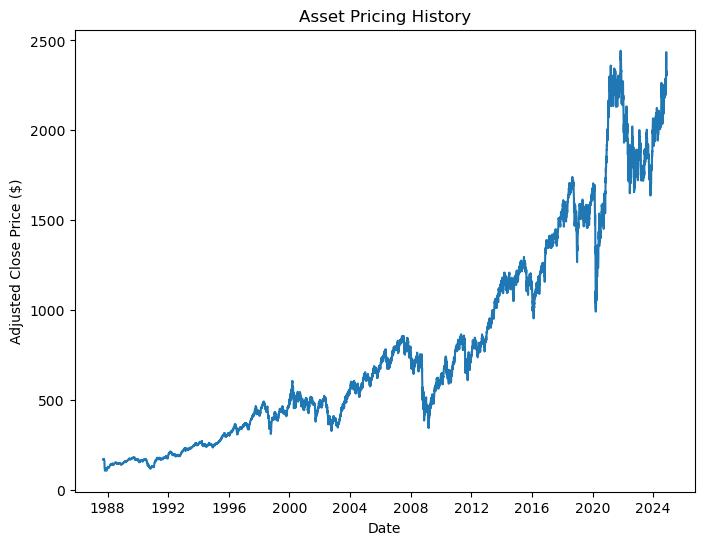


----------
Time Span: 446 months
Number of points sampled: 9373


In [2]:


# get data


dates,prices = load.assetHist_CSV(dataDir+'/'+datasetName, sep='\t')

#dates = dates[2500:]
#prices = prices[2500:]

print('')
print('----------')
print('Time Span: '+str(np.datetime64(dates[-1], 'M')-np.datetime64(dates[0], 'M')))
print('Number of points sampled: '+str(len(dates)))



### ii. Caculate Returns
In the future, we will be considering many estimates over monthly relative returns.
We feel this may actually be a more important feature, vs price, 
to look at for exploring certain detials.  For example, 
in Projects 202407 and 20409, we found long term memory and high noise 
(as determined from the autocorrelation function) in the price. 
Therefore we chose to consider the returns for determining the samplining frequence.

Here we defined a month to be 21 consecutive adjusted closing day prices. 
We are considering set 30 day period for a month. 
Stock is traded and recorded only when the market is open, 
so our time series only contains weekdays.
We are removing 2 weekends days per week. 
A 30 day month, given 4.25 weeks each month, yields 8.5 weekend days.
We removed 9 days to account for a handful of holidays.
Importantly, this is consistant with the number of data points over a
spepcific range of time as confirmed in past studies.

As a matter of practice, we are considering relative returns.
 


[-0.0168669  -0.0391697  -0.03690665 ...  0.01007958  0.01329034
  0.03800492]
['1987-10-09T00:00:00.000000000' '1987-10-12T00:00:00.000000000'
 '1987-10-13T00:00:00.000000000' ... '2024-11-15T00:00:00.000000000'
 '2024-11-18T00:00:00.000000000' '2024-11-19T00:00:00.000000000']


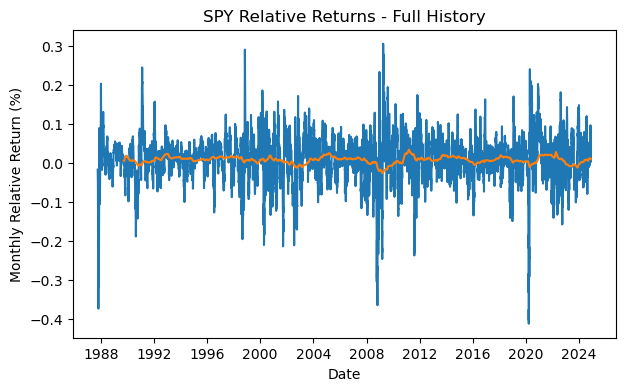

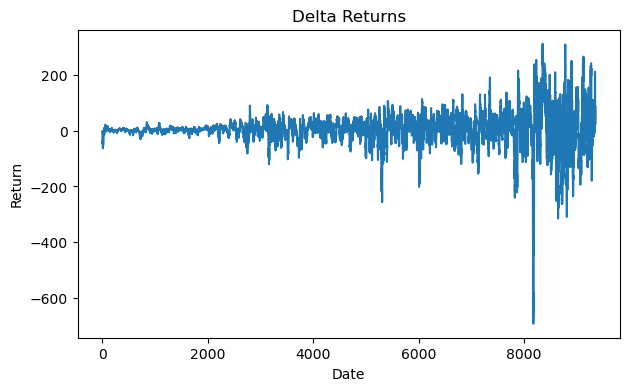

In [3]:
# conversion factor for months to consecutive points *USER SET*
month2days = 21

returns = genFin.returns(prices,period=month2days)
inds = np.arange(0,len(returns))+month2days
dates_returns = dates[inds]

# Show for sanity check
print(returns)
print(dates_returns)

# moving averages for fun
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

returnsMA = moving_average(returns, 500)

# Plot the data for sanity check
plt.figure(figsize=(7, 4))
plt.plot(dates_returns, returns)
plt.plot(dates_returns[499:], returnsMA)

plt.xlabel('Date')
plt.ylabel('Monthly Relative Return (%)')
plt.title('SPY Relative Returns - Full History')
plt.show()

#Plot the non relative data for fun
plt.figure(figsize=(7, 4))
plt.plot(np.arange(0,len(returns)), genFin.returns(prices,period=month2days,metric='Delta'))
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Delta Returns')
plt.show()


General we found the relative returns to show now clearly visible trend.
There are three clear low points in the curve.
These points corispond to 1987's Black Monday, 2008 housing crisis and the COVID pandemic.  
Not suprisingly, this was the same for the S&P 500 (Project 202411_apa_SP500).


Alternativly the absolute returns clearly show a qualitative explosion of variability 
around the 2000 and 2020. 
This corrisponds to the 2000 Dot Com Bubble and the COVID pandemic, respectivly.
In both cases, much of this variability seems to persist.



## II. Sampling Frequency/Interval 

For any statistical analysis, we have to determine how much time will pass 
between t<sub>i</sub> and <sub>i+1</sub> in our data set. 
In our experience, this is often arbitrarily determined, 
but here we considered a more formal statistical approach. 
We want to maximize the number of sampling points while minimizing their dependence since a proper statistical analysis would require statistically independent samples.
We would like to select a sampling rate that minimizes the statistical dependance between data points that is driven simply by proximity in time, 
but keep as many data points as possible to boost statistical power. 
In a perfect senario this would be done by considering the elapsed time for the Auto-Correlation Function (ACF) to drop and then remain at zero. 
Of course, in any real-world data there is noise that keeps this from happening. 
In complex non-linear systems like the stock market 
there is also the high possibility of long-term memory effects as observed 
when the ACF does not approach zero or deviates from it after a period of time. 
We arbitrary chose a cutoff of +/-0.05 around the zero to be considered 'reasonably' near zero.

Previously (Project 202409), we formulated a set of rules 
to systematically select a sampling frequency from the ACF. 
First, we chose to require that the zero was within the 95% CI of the ACF value. 
This is a necessary but not a sufficient condition for being near zero. 
We also chose to require the ACF value to be within the cutoff range 
defined above as +/- 0.05. 
We went further to require the above to be true for one month, 
defined above as 21 days (i.e. 21 consecutive data points in the time course). 
Since the returns are 21 days, it stands to reason we would like our samples to be spaced such that they are nearly uncorrelated over 21 days.

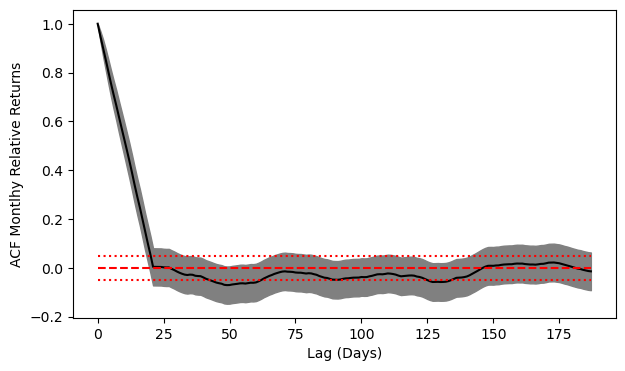

Return ACF
[ 1.          0.94989064  0.90302191  0.85523176  0.80637972  0.75726354
  0.71117422  0.66766414  0.62105121  0.57588073  0.53096022  0.48515225
  0.43906614  0.39045394  0.33971553  0.29180951  0.24697696  0.19760247
  0.14720307  0.10050316  0.05431914  0.00393478  0.00372685  0.00355262
  0.00342787  0.0019721   0.00133833  0.00141779 -0.00412784 -0.00908059
 -0.01503854 -0.02018307 -0.02450325 -0.02806512 -0.02953557 -0.0279271
 -0.02863266 -0.03264645 -0.03377955 -0.03431657 -0.03909771 -0.04470564
 -0.04848456 -0.05243093 -0.0567488  -0.06058467 -0.06317829 -0.06526696
 -0.06977364 -0.07095144 -0.07059484 -0.06837751 -0.06705569 -0.06552917
 -0.06379795 -0.06353068 -0.06457115 -0.06298477 -0.06115783 -0.06139034]
Return ACF 95% Conf
[[ 1.          0.92962334  0.86908048  0.81254765  0.75715762  0.70288513
   0.65262412  0.60566723  0.55616798  0.50859997  0.46168432  0.41422444
   0.36678808  0.31708847  0.2655014   0.21695934  0.17166095  0.12195452
   0.07134339  0.

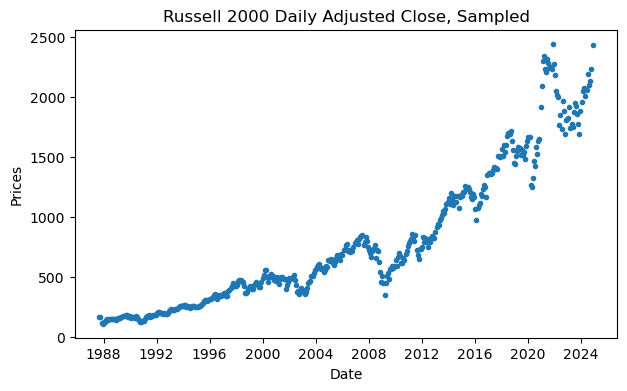

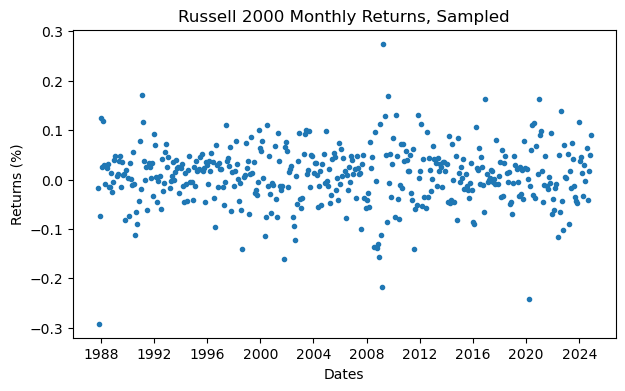

In [4]:
# +/- cutoff for 'near zero' ACF values *USER SET*
acfCutoff = 0.05

# Calc autocorr
acf_return, lag_return, acfConf_return = genStats.acf(returns,fracLag=0.02)


# Plot the data for sanity check
plt.figure(figsize=(7, 4))
plt.plot(lag_return, acf_return,color='black',label='full')

plt.plot(lag_return, lag_return*0 ,'r--') 
plt.plot(lag_return, lag_return*0 + acfCutoff,'r:') 
plt.plot(lag_return, lag_return*0 - acfCutoff,'r:') 
plt.fill_between(lag_return,acfConf_return[:,0],acfConf_return[:,1],color='gray')
plt.xlabel('Lag (Days)')
plt.ylabel('ACF Montlhy Relative Returns')
#plt.title('')
plt.show()


print('Return ACF')
print(acf_return[:60])
print('Return ACF 95% Conf')
print(acfConf_return[:60].T)


sampFreq = apa.find_samp_freq(returns, cutoff=acfCutoff, period=month2days, fracLag=0.02)


print('Samp Freq')
print('- Full Data Set '+str(sampFreq))

# Parse out the proper sample data
n = len(prices)
inds = np.arange(0,n,sampFreq)
prices_samp = prices[inds]
dates_samp = dates[inds]


n = len(returns)
inds = np.arange(0,n,sampFreq)
returns_samp = returns[inds]
dates_returns_samp = dates_returns[inds]

# Plot the data for sanity check
plt.figure(figsize=(7, 4))
plt.plot(dates_samp,prices_samp,'.')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.title('Russell 2000 Daily Adjusted Close, Sampled')
plt.show()

# Plot the data for sanity check
plt.figure(figsize=(7, 4))
plt.plot(dates_returns_samp,returns_samp,'.')
plt.xlabel('Dates')
plt.ylabel('Returns (%)')
plt.title('Russell 2000 Monthly Returns, Sampled')
plt.show()



We found a sampling frequency as low as 21 days was sufficent to 
meet the pre-determined selection criterion.
Classical modeling of returns often considered a 
constant return with a random noise component.
If this holds then it is expected for returns to have a 
raipidly dropping auto correlation function, as obsered here.
Our result of 20 days was probably only limited by the 
fact we defined our returns as 21 day intervals.
These results were consistant with the S&P 500 interval of 20 days (Project 202411_apa_SP500).




## III. Asset Deviations
Here we identified deviations in the price that were 'meaningfully' different 
from what one might expect given the 'simple' underlying trend of the data.
To do this we need to identify an underlying trend, define what is 
'meaningfully' different and identify sequental occurances of this trend.

### i. Priceing Trend 
We will be considering several 'simple' models for an underlying price trend.

Models:
* Polynomials 1-8th order
* exp function
* logrithmic function

All models were fit by transforming variables and then 
using the statsmodel library ordinary least squares solver.
In projects 202407, 202409 and 202410, we chose to use the maximum 
adjusted R-Squared value for the model selection criterion.
We applied the same here. 

Note that we used the modified, smaller samplied data set
for determining quantaties of a statistical nature.




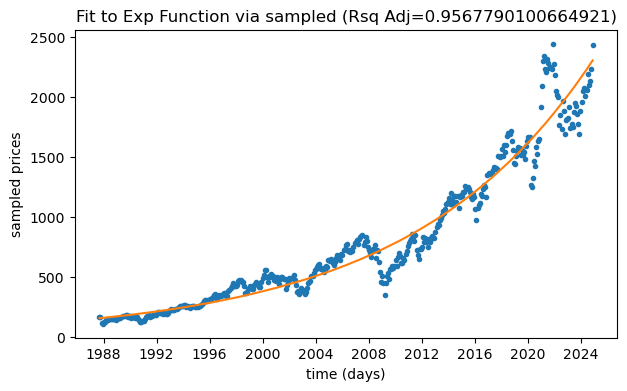

[5.03926834e+00 2.88580873e-04]


In [5]:


### fit trend line
maxPolyOrder = 8
# need consecutive numbers, not dates, values not important, evenly spaced
x = np.arange(0,len(dates),1)
n = len(dates)
inds = np.arange(0,n,sampFreq)
x_samp = x[inds]
xScaleFact = 1
x4Fit = x/xScaleFact


rsqAdj, name, model, prices_sampHat = genStats.fit_simp_model(x_samp, prices_samp, maxPolyOrder)

# Plot the data for sanity check
plt.figure(figsize=(7, 4))
plt.plot(dates_samp, prices_samp,'.',dates_samp,prices_sampHat,'-')
plt.xlabel('time (days)')
plt.ylabel('sampled prices')
plt.title('Fit to '+name+' via sampled (Rsq Adj='+str(rsqAdj)+')')
plt.show()

print(model.params)



We found that a simple exponental function produced the best fit.
This is a notable difference compared to the 7th order poly fit 
used for the S&P 500 (Project 202411_apa_SP500).
However, because the fit relies on many parametric and methodlogical choices
and the number of observations compared to parameters for any of the 
function options is great,
we are not going to over interpret this difference.
It should be noted that a simple exponental fit produced reasonable 
results on an early assessment of the S&P 500 (Project 202407).

### ii. Define Deviations
We considered the price to be based on both a 'drift' and a 'noise' term.
In a perfect world, the drift would be defined by the trend and 
the noise by a uniformly distributed independnat random variable.
However (and as expected), there are clear deviations away from and 
back to the trend line over meaningfully long periods.
These are also easy to link to particular market events known to effect
the overall US economy.
In Project 202410, we chose to purse these further as abnormal deviations events.
We did the same here by considering the dispersion around the trend line
and the prices that are abnormally high or low.
Specifcally, we considered the possibility +/- 
the Median Absolute Deviation (MAD; corrected to match stdev under normality)
as a definition for abnormal price behaviour.
In Project 202410 we considered other options but dcided to move forward with MAD.



Dispersion (MAD): 0.1621238827385168


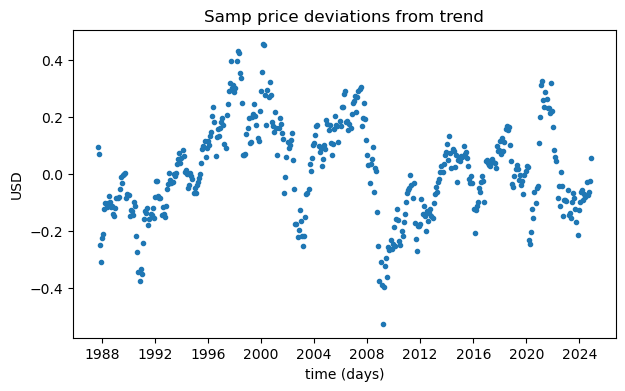

In [6]:

# consider deviations
method = 'MAD'

# get deviations
dev = genFin.dev(prices_samp,prices_sampHat)



sigma = genStats.disper(dev,method=method)
print('Dispersion (MAD): '+str(sigma))


# Plot the data for sanity check
plt.figure(figsize=(7, 4))
plt.plot(dates_samp, dev,'.')
plt.xlabel('time (days)')
plt.ylabel('USD')
plt.title('Samp price deviations from trend')
plt.show()




We found the typical expected price deviation to be +/- 0.16, 
slightly lower than the 50 years of past S&P 500 data).

### iii. Identify Deviation Events
We defined a deviation event as a sequence of consecutive price
deviations that stay above the abnormal deviation threshold.
This period, in total, would be one deviation event of some period length.

Note: unlike the statistical tests where we used the sampled data, 
here we considered different resolutiobs starting with the full data set.
This is because we do not need the data set to be independently distributed.
In fact, we are in some sense suggesting that there is a dependance 
between the prices in a given event period.
This is somewhat related to the observations of long-term price memory 
in other projects and why we had to base sampiling on the return.

-------------------------------
--Deviations Root From Months--
-------------------------------


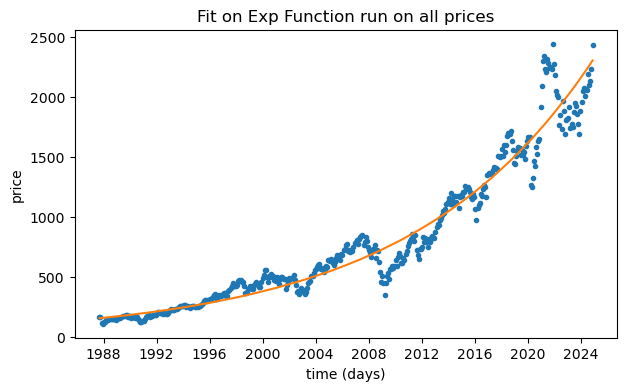

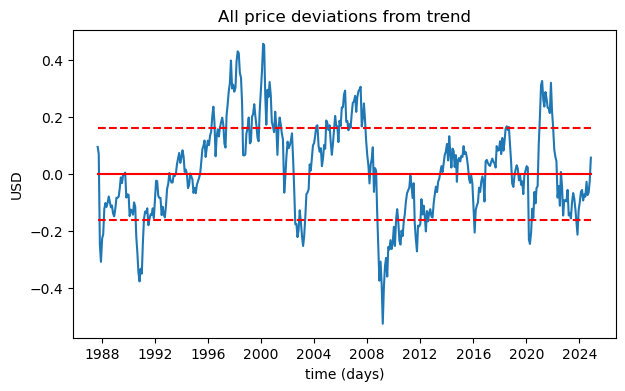

Threshold: 0.1621238827385168
Method: MAD
Number of Events: 31
Expected Event Length (M): 4.333333333333333
Abnormal Event Length (M): 8.498739566277644
Rare Event Length (M): 16.829552032166266
Crazy Event Length (M): 25.160364498054886
Event Lengths:
[ 29.  29.  30.  30.  31.  32.  32.  32.  32.  32.  59.  61.  61.  62.
  90.  91.  91.  94. 122. 122. 123. 152. 181. 183. 212. 245. 396. 396.
 398. 455. 490.]
Total Time:
4393.0


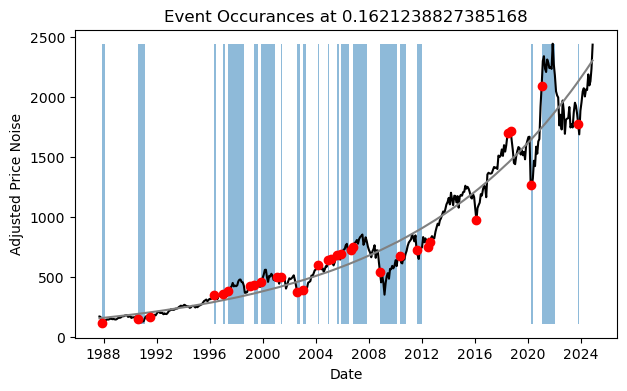

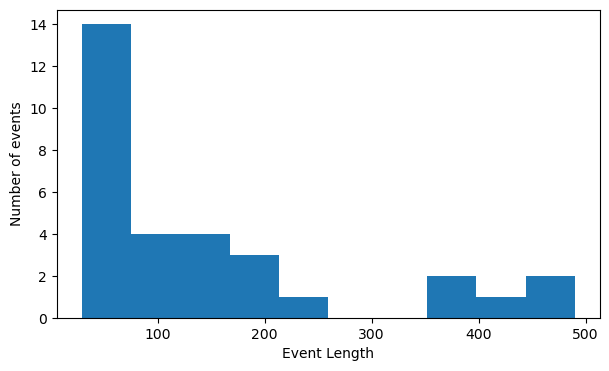

In [8]:
# first we need the trend for the whole data set


pricesHat = genStats.run_model(x4Fit,model,name)


print('-------------------------------')
print('--Deviations Root From Months--')
print('-------------------------------')


# get the disiered subset
n=len(dates)
inds=np.arange(0,n,month2days)
x=dates[inds]
y=prices[inds]
yHat=pricesHat[inds]

thresh = sigma

# Plot the data for sanity check
plt.figure(figsize=(7, 4))
plt.plot(x, y,'.',x,yHat,'-')
plt.xlabel('time (days)')
plt.ylabel('price')
plt.title('Fit on '+name+' run on all prices')
plt.show()

devs = genFin.dev(y,yHat)
absDevs = np.abs(devs)

# Plot the data for sanity check
plt.figure(figsize=(7, 4))
plt.plot(x, devs)
plt.plot(x, devs*0,'-r')
plt.plot(x, devs*0+thresh,'--r')
plt.plot(x, devs*0-thresh,'--r')
plt.xlabel('time (days)')
plt.ylabel('USD')
plt.title('All price deviations from trend')
plt.show()
    

    
# flag deviations for this metric
eventInd, eventTime, eventLength = apa.flag_dev_event(x,y,yHat,thresh)

# need floats not timedelays for some processing
eventDays=utils.ns2days(eventLength)
    
print('Threshold: '+str(thresh))
print('Method: '+method)
print('Number of Events: '+str(len(eventTime)))
eventExp = np.median(eventDays)/month2days
print('Expected Event Length (M): '+str(eventExp))
eventDisper = genStats.disper(eventDays,method)/month2days
print('Abnormal Event Length (M): '+str(eventExp+eventDisper))
print('Rare Event Length (M): '+str(eventExp+3*eventDisper))
print('Crazy Event Length (M): '+str(eventExp+5*eventDisper))
print('Event Lengths:')
print(np.sort(eventDays))
print('Total Time:')
print(np.sum(eventDays))
inds = np.array(eventInd)
    
# Plot the data
plt.figure(figsize=(7, 4))
plt.plot(x, y,color='black')
plt.plot(x, yHat,color='gray')
plt.plot(x[eventInd],y[eventInd],'or')

plt.fill_between(x, min(y), max(y), where=(absDevs > thresh), alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Adjusted Price Noise')
plt.title('Event Occurances at ' + str(thresh))
plt.show()

    
plt.figure(figsize=(7, 4))
plt.hist(eventDays)
plt.xlabel('Event Length')
plt.ylabel('Number of events')
plt.title('')
plt.show()






We found the expected time for an abnormal event to be about four months.
Unusual event lenthgs are between 8 and 16 months (1 and 3 deivations)
with extreamlly rare events being longer than 25 months (5 deviations).
We use this data to support the suggestions regarding small cap US stocks to long- and mid-term investors that: 
* abnormal price deviations, as the name suggests, are not common but are to be expected;
* these events are expected to last about 4-8 months for small cap US stocks;
* regular reallocation via standard optimization should be done every 8 months (or less);
* early exiting or entering small cap stocks should not be driven only by recent price trends less than 8 months;
* some investors with shorter time horizans may want to consider re-allocation based on other market factors for events lasting longer than 8 months;
* outside of other major factors, true long-term/ buy-and-hold investors should consider *not* making major changes based on events shorter than 17 months;  
* all investors are encuraged to consider re-allocation based on other market factors for events lasting longer than 17 months;
* however, don't excessivly run into or out of stocks simply because they have been on a 17 month up or down streak as there are several historical examples of market corrections even at this time-scale (what goes up must come down, sort of); and  
* events lasting longer than 25 months are of extream concern and may indicate fundemental changes.

There were no unexpected observations and 
all major market events were captured by the analysis.
We do note two observations.
First, more deviation events registarted as abnormal 
compared to the large cap S&P 500 (Project 202411_apa_SP500).
Secondly, the post COVID recovery bubble,
the high side specfically,
was far more signficant in small vs large cap (Project 202411_apa_SP500).
Here, it not only registared as an unexpectedly high in value,
but the value was held high at the long end of abnormal event lengths overall.
The next comparable event was the warm-up to the 2000 market crash. 


## IV. Sampiling Period
The Mean-Variance analysis of Modern Portfolio Theory relies on 
statistical estimates of a expected return and risk 
(variance or other dispersion metric) parameters.
As shown above, we have considered median realitive return 
and its Median Absolute Deviation (MAD).
To calculate these, 
we need a proper sampiling frequency (determined in Section II)
and a sampiling period (number of consecutive time points to analyze over).

Previous analysies have shown that short sampiling periods lead to 
low-biased estimates of risk, as expected with small sample sizes.
However, long sampling periods (10, 20, 50 years) may not be avalible,
require additional compute resources and may not hold information relavant 
to the current market.

Here we applied the same method from project 202410.
We considered the period selection problem to be a 
standard paramater optimization problem.
Given that the goal of estimating a return over a given period 
is to use that as an estimate for future returns,
we chose to use the estimated expected return for a given period length
as the 'predictor' and to use some future return as the 'actual' observation.
For this future or actual return 
we chose a time delta equivlant to the suggested reallocation time (6mo).
An estimate of the expected return is calculated over a given period.
This is then compared to the return 6 months following the end of that period.

The objective function was simply normalized squared error,
where the normalization factor was the estimated dispersion 
(reffered to below as Risk Adjusted Error).
We focused on this Risk Adjusted Error
because it directly relates to the mean-variance method 
of optimizing expected return over risk.







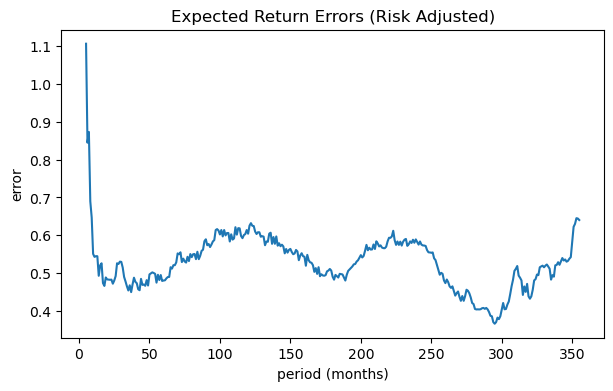

- Min Error: 0.3661173372785912
- Min Period: 295.0


In [9]:
# set method for estimatig return properties
method='Robust'
# reallocation time determined above
# used for delta between estimate and actual return
# 6 months in trading days
actDelta = 6*21
# adjust for samp freq (must be int)
actDelta = int(actDelta/sampFreq)

# set a max length based on total possible length (must be int)
pMax = int(0.80*len(returns_samp))
# requiering at least  data points for min
pMin = 5

# get the period range for later use
period = np.arange(pMin,pMax,1)
# for readability change to months
period = period*sampFreq/month2days


# get the errors
error = apa.calc_period_error(returns_samp,pMin,pMax,actDelta,scale='Disp',method=method)

# Plot the data 
plt.figure(figsize=(7, 4))
plt.plot(period, error)
plt.xlabel('period (months)')
plt.ylabel('error')
plt.title('Expected Return Errors (Risk Adjusted)')
plt.show()

# find and print minimum
minInd = np.argmin(error)
print('- Min Error: '+str(error[minInd]))
print('- Min Period: '+str(period[minInd]))





This shows that using:
(a) relative monthly (21 trading days) returns,
(b) a sampling interval of 21 trading days,
(c) a sample period of 295 months,
(d) a robust method for return parameter estimates and
(e) a reallcation target of 6 months,
we could typically expect a future return to 
be at a minumum (and well below) relative to the estimated dispersion.
We found this to be a sufficent result.

The minimum squared risk adjusted error was comparable to the large cap market 
as determined from the S&P 500 (Project 202411_apa_SP500).
The optimal period was shorter; however, the Russell 2000
is not as old as the S&P and there not enough data to 
properly test the long period times tested for the S&P 500.
Like the S&P 500 there was another local minimum around 200 months,
but in this case the valley is closer to 175 months.
Interestingly, the Russell shows resonable error values as low as 30-50.
This could support the use of shorter periods for small cap stocks
without the need for a red flag.

Given the results here and those from other projects, 
we have made the following suggestions for similar, *small* cap equity assets and period selection:
* 25 years if possible;
* if not, then 15 years if possible;
* if not, then use the maximum avalible between 30 and 50 months and issue a yellow flag to the user; and
* issue a red flag if bellow 30 months (2.5 years).





## V. Historical Returns
A simple analysis was done regarding the average portfolio return 
depending on portfolio hold time.
We suggest that the longer a portfolio is held, the high the return.
We looked at relative returns in one month increments from zero to over about 11 years.
Averages were taken over the full SPY time course used above (1993-2024).

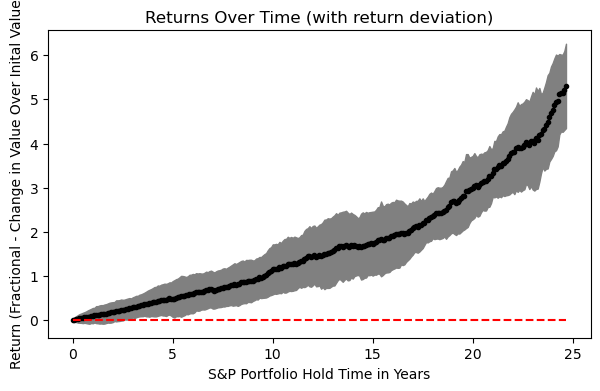

Return: 5.3053284465745705 at 24.666666666666668 for an annual of 0.21508088296923933
Return: 1.9661231931929286 at 16.5 for an annual of 0.11915898140563204 +/- 0.04361935645207582


In [11]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


# calculate history of running returns 
returnHist, returnHistDisp, returnHistTime = apa.calc_running_returns(prices_samp,maxHoldFrac=0.666)

# convert hold time into years
returnHistTime = returnHistTime*sampFreq/month2days/12

plt.figure(figsize=(7, 4))
plt.plot(returnHistTime,returnHist,'.',color='black')
plt.plot(returnHistTime,returnHist*0,'--',color='red')
plt.fill_between(returnHistTime,returnHist+returnHistDisp,returnHist-returnHistDisp,color='gray')
plt.xlabel('S&P Portfolio Hold Time in Years')
plt.ylabel('Return (Fractional - Change in Value Over Inital Value')
plt.title('Returns Over Time (with return deviation)')
plt.show()

print('Return: '+str(returnHist[-1])+' at '+str(returnHistTime[-1])+
      ' for an annual of '+str(returnHist[-1]/returnHistTime[-1]))

# print the value if we held for the 16.5 years explored in previous project
targetYear = 16.5
ind = find_nearest(returnHistTime, targetYear)
print('Return: '+str(returnHist[ind])+' at '+str(returnHistTime[ind])+
      ' for an annual of '+str(returnHist[ind]/returnHistTime[ind])+
      ' +/- '+str(returnHistDisp[ind]/returnHistTime[ind]))





We found that holding a portfolio representitive of the 
Russell 2000 for 25 years would provide a ~500% increase 
over the inital investment, which is an average of 21.5% annually.

To better compare the the analysis done on the Large Cap S&P 500, 
we considered a hold time of 16.5 years.
In this range, we found an annual average return of 12% +/- 4% for small cap
compared to the 16% +/- 10% for large cap.
The S&P 500 (a far more popular replication target for various funds)
yeilds a higher return for long-term investment.
However, the variability is also larger - the deviation is more than double.
This suggests that a well diversified small cap fund may have a lower yeild 
than the more popular large cap funds, but may also be a safer investment.

We also noted that, consistant with the S&P 500 analysis, 
a loss is within the typical deviation for hold time of less than ~2.5 years.

Personal note, we found it supprising that this small cap index had lower variability 
than the large cap S&P 500.
We expected more volitility from an index of smaller companies.
We also noted the higher number of abnormal price deviations.
This results further motivate a well-balanced portfolio to 
combine assets from both large and small cap equities.

## IV. Summary
Using this data we make the following suggestions for robust statistical 
parameters describing a *small* cap US equity asset:
* 21 trading day relative returns;
* sampling frequence, or more properly interval of 21 trading days; and
* sampling period of 25 years if possible (otherwise 15 years, otherwise yellow flag and red flag if less than 2.5 years);

For portfolios of these assets we also suggest:
* an expectation of 8-16% annual return on average if held for mid- to long-term investment;
* shorter innvestment time frames, less than 2.5 years, were noted for a higher possibility for loss;
* a reallocation based on robust optimization every 8 months or less;
* investors should expect seemingly wilde market swings lasteing between 4-8 months;
* long-term invstors (expecting to hold for 10+ years) should avoid making changes based only on an unexpected change in an assets trend even if that change has presisted for 16 months; but
* all investors should start considering other market factors if an asset is deviating from its expected trend for more than a 2 years. 